In [90]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [130]:
class Dataset(Dataset):
    def __init__(self):
        test = pd.read_csv('data/train.csv')
        del test['Ticket']
        del test['Fare']
        del test['Cabin']
        del test['Name']
        del test['Embarked']
        test['Sex'] = test['Sex'].map({"male": 0, "female": 1}).astype(np.int8)
        test['Age'] = test['Age'].fillna(value=test['Age'].median())
        self.data = test
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        target = self.data.iloc[index].tolist()[1]
        sample = self.data.iloc[index].tolist()[2:]
        
        target = torch.tensor(target)
        sample = torch.tensor(sample)
        return target, sample

In [131]:
data = Dataset()
train_set, val_set= random_split(data,[0.9,0.1])
train_loader = DataLoader(train_set,batch_size = 8, shuffle= True)
val_loader = DataLoader(val_set,batch_size = 8, shuffle= False)

In [174]:
model = nn.Sequential(
    nn.Linear(5, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    
)


train_loss = []
val_loss = []
accuracy_train =[]
accuracy_val =[]
lr = 0.005
load = True

if load:
    weights = torch.load('model/model1.pt', weights_only=True)
    model.load_state_dict(weights)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.5) 



In [170]:

for i in range(5):
    model.train()
    
    train_loop = tqdm(train_loader,leave=True)
    correct = 0 
    total = 0
    mean_loss = []
    
    for target, x in train_loop:
        
        target = target.unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_loss.append(loss.item())
        train_loop.set_description(f"Epohs:{i} loss: {loss.item():.4f}")
        
    train_loss.append(sum(mean_loss) / len(mean_loss))
    mean_loss =[]
    with torch.no_grad():
        model.eval()
        val_loop = tqdm(val_loader,leave=True)
        for target, x in val_loop:
            
            target = target.unsqueeze(1)
            pred = model(x)
            loss = loss_fn(pred,target)
            mean_loss.append(loss.item())
            val_loop.set_description(f"Epohs:{i} loss: {loss.item():.4f}")
    
    val_loss.append(sum(mean_loss) / len(mean_loss))
    # scheduler.step()
    

Epohs:4 loss: 0.0774: 100%|██████████| 12/12 [00:00<00:00, 726.49it/s]


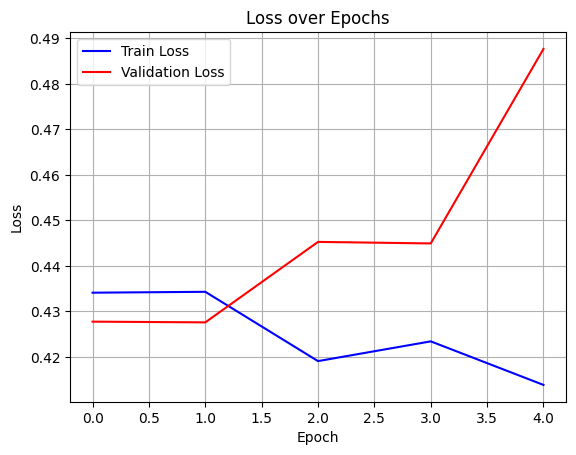

In [171]:
# Построение графика
plt.plot(train_loss, label='Train Loss', color='blue')  # Синим график обучающих потерь
plt.plot(val_loss, label='Validation Loss', color='red')   # Отображаем график потерь
plt.xlabel('Epoch')  # Подпись оси X (например, эпохи)
plt.ylabel('Loss')  # Подпись оси Y (значения потерь)
plt.title('Loss over Epochs')  # Заголовок графика
plt.legend()  # Легенда
plt.grid(True)  # Включение сетки
plt.show() 

In [175]:
data1 = Dataset()

total = len(data)
corect = 0
for target, x in data1:
    out = model(x)
    out = torch.clamp(out, 0, 1)
    if out.item() == target.item():
        corect += 1

accuracy = (corect / total) * 100
print(f"correct: {corect} / {total}")
print(f"accuracy {accuracy}")


correct: 712 / 891
accuracy 79.91021324354658


In [173]:
torch.save(model.state_dict(), 'model/model1.pt')

In [ ]:
class testData(Dataset):
    def __init__(self):
        test = pd.read_csv('data/test.csv')
        del test['Ticket']
        del test['Fare']
        del test['Cabin']
        del test['Name']
        del test['Embarked']
        test['Sex'] = test['Sex'].map({"male": 0, "female": 1}).astype(np.int8)
        test['Age'] = test['Age'].fillna(value=test['Age'].median())
        self.data = test
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        target = self.data.iloc[index].tolist()[1]
        sample = self.data.iloc[index].tolist()[2:]
        
        target = torch.tensor(target)
        sample = torch.tensor(sample)
        return target, sample

In [176]:
data1[0]

(tensor(0.), tensor([ 3.,  0., 22.,  1.,  0.]))